In [21]:
import os
import pandas as pd
import requests
import numpy as np

oil = pd.read_csv("C:\\Users\kimhongbum\PycharmProjects\BA\data\oilprice.csv")
# 날짜데이터를 Datetime 형식으로 바꿔준다
oil.loc[:,'Date'] = pd.to_datetime(oil.Date)
# 결측치 확인
print(oil.isna().sum().sum())

0


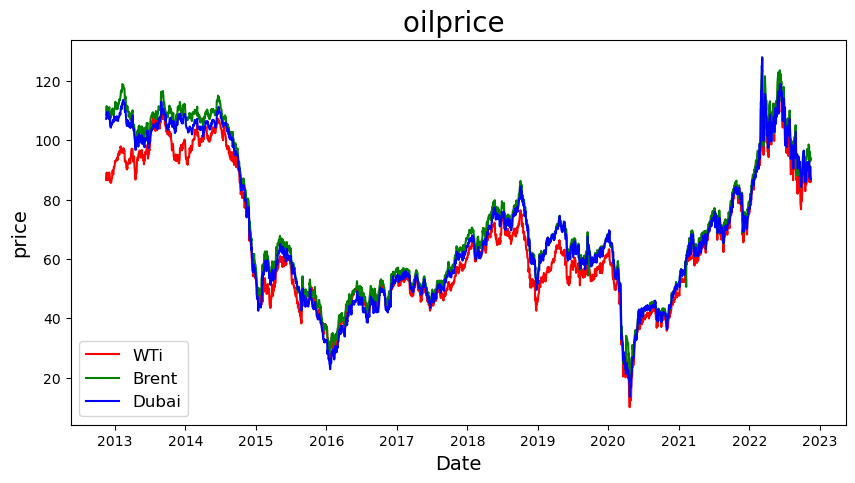

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(oil.Date, oil.WTi, color='r')
plt.plot(oil.Date, oil.Brent, color='g')
plt.plot(oil.Date, oil.Dubai, color='b')

plt.title('oilprice ', fontsize=20)
plt.ylabel('price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['WTi', 'Brent', 'Dubai' ], fontsize=12, loc='best')

plt.show()

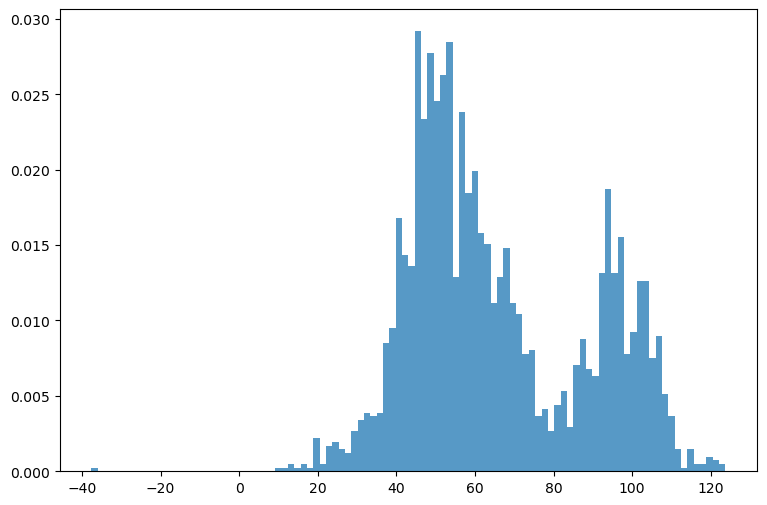

In [24]:
# WTi 데이터의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(oil.WTi, 100, density=True, alpha=0.75)

In [25]:
minus = oil[oil["WTi"] <0].index

In [26]:
oil.drop(minus, inplace = True)

In [27]:
oil.reset_index(drop=True, inplace=True)

In [28]:
oil

,Date,WTi,Brent,Dubai
0,2022-11-15,86.92,93.86,86.83
1,2022-11-14,85.87,93.14,91.04
2,2022-11-11,88.96,95.99,91.05
3,2022-11-10,86.47,93.67,87.18
4,2022-11-09,85.83,92.65,89.80
...,...,...,...,...
2543,2012-11-22,87.08,110.29,108.74
2544,2012-11-21,87.08,110.57,108.54
2545,2012-11-20,86.70,109.89,109.51
2546,2012-11-19,89.12,111.51,108.41


In [30]:
from statsmodels.stats.weightstats import ztest

_, p = ztest(oil.WTi)
print(p)  # 0

0.0


In [33]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler


# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['WTi', 'Brent', 'Dubai']
n_features = len(features)
TRAIN_SIZE = int(len(oil)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(oil.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(oil[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
checkpoint_path = 'C:\\Users\\kimhongbum\PycharmProjects\BA\\mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen,
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50,
          callbacks=[checkpoint, early_stop])


model.load_weights(checkpoint_path)
# <tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7fa7e4312910>

(32, 10, 3)
(32, 3)
Epoch 1/50
76/80 [===========================>..] - ETA: 0s - loss: 1.0766 - mae: 1.0766
Epoch 1: val_loss improved from inf to 1.29462, saving model to C:\Users\kimhongbum\PycharmProjects\BA\mymodel.ckpt
80/80 [==============================] - 5s 23ms/step - loss: 1.0641 - mae: 1.0641 - val_loss: 1.2946 - val_mae: 1.2946
Epoch 2/50
79/80 [============================>.] - ETA: 0s - loss: 0.4494 - mae: 0.4494
Epoch 2: val_loss improved from 1.29462 to 0.65085, saving model to C:\Users\kimhongbum\PycharmProjects\BA\mymodel.ckpt
80/80 [==============================] - 1s 13ms/step - loss: 0.4454 - mae: 0.4454 - val_loss: 0.6509 - val_mae: 0.6509
Epoch 3/50
76/80 [===========================>..] - ETA: 0s - loss: 0.1865 - mae: 0.1865
Epoch 3: val_loss improved from 0.65085 to 0.16019, saving model to C:\Users\kimhongbum\PycharmProjects\BA\mymodel.ckpt
80/80 [==============================] - 1s 14ms/step - loss: 0.1862 - mae: 0.1862 - val_loss: 0.1602 - val_mae: 0.16

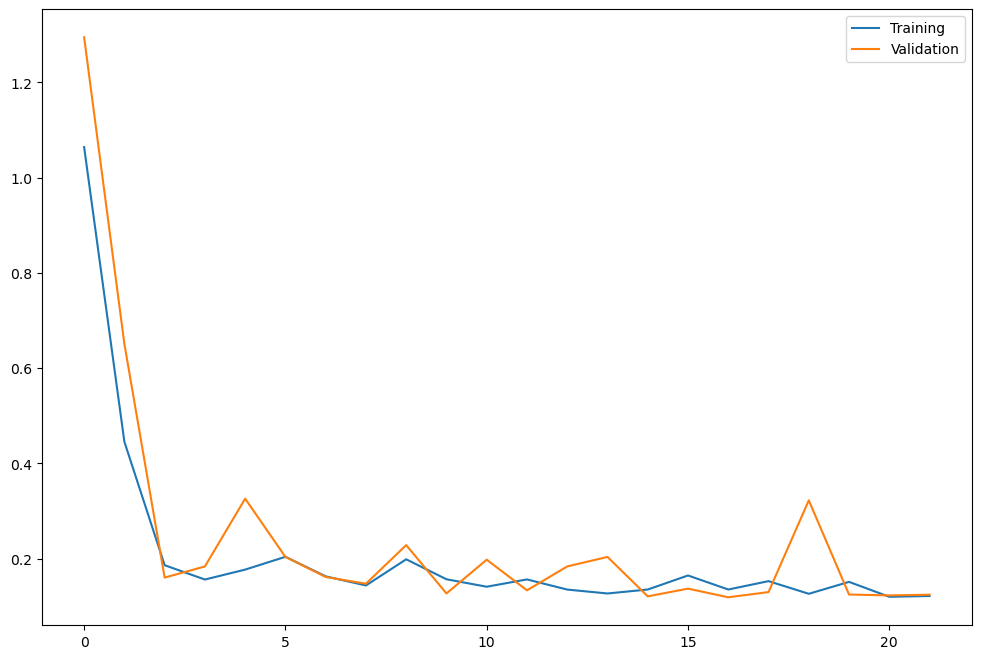

In [35]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

80/80 [==============================] - 1s 3ms/step


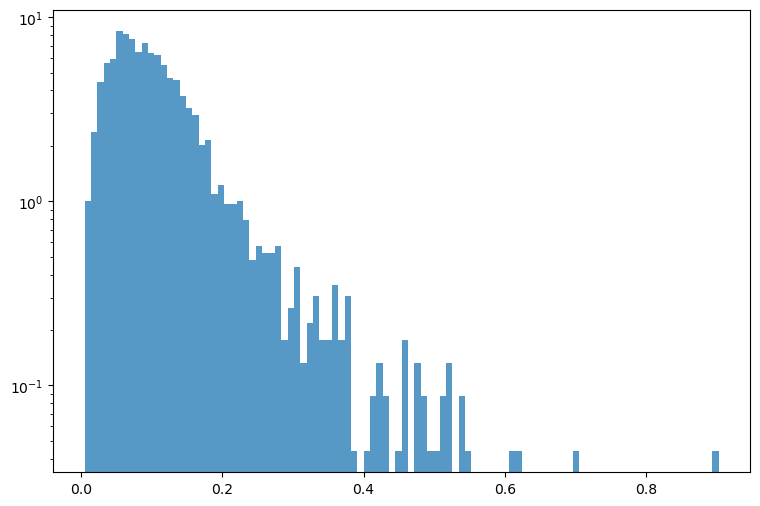

In [36]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [40]:
import copy

test_df = copy.deepcopy(oil.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 0.5
test_df.loc[test_df.Loss>threshold]

,Date,WTi,Brent,Dubai,Loss
94,2022-06-14,118.93,121.17,118.67,0.512502
96,2022-06-10,120.67,122.01,118.94,0.524421
97,2022-06-09,121.51,123.07,118.83,0.536816
98,2022-06-08,122.11,123.58,116.52,0.501889
146,2022-03-24,112.34,119.03,115.60,0.520258
158,2022-03-08,123.70,127.98,122.99,0.902744
159,2022-03-07,119.40,123.21,125.19,0.703399
164,2022-02-28,95.72,100.99,96.86,0.541402
165,2022-02-25,91.59,97.93,95.84,0.607052
167,2022-02-23,92.10,96.84,93.65,0.522342


C:\Users\kimhongbum\anaconda3\envs\BA_Tutorial\lib\site-packages\matplotlib\lines.py:189: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


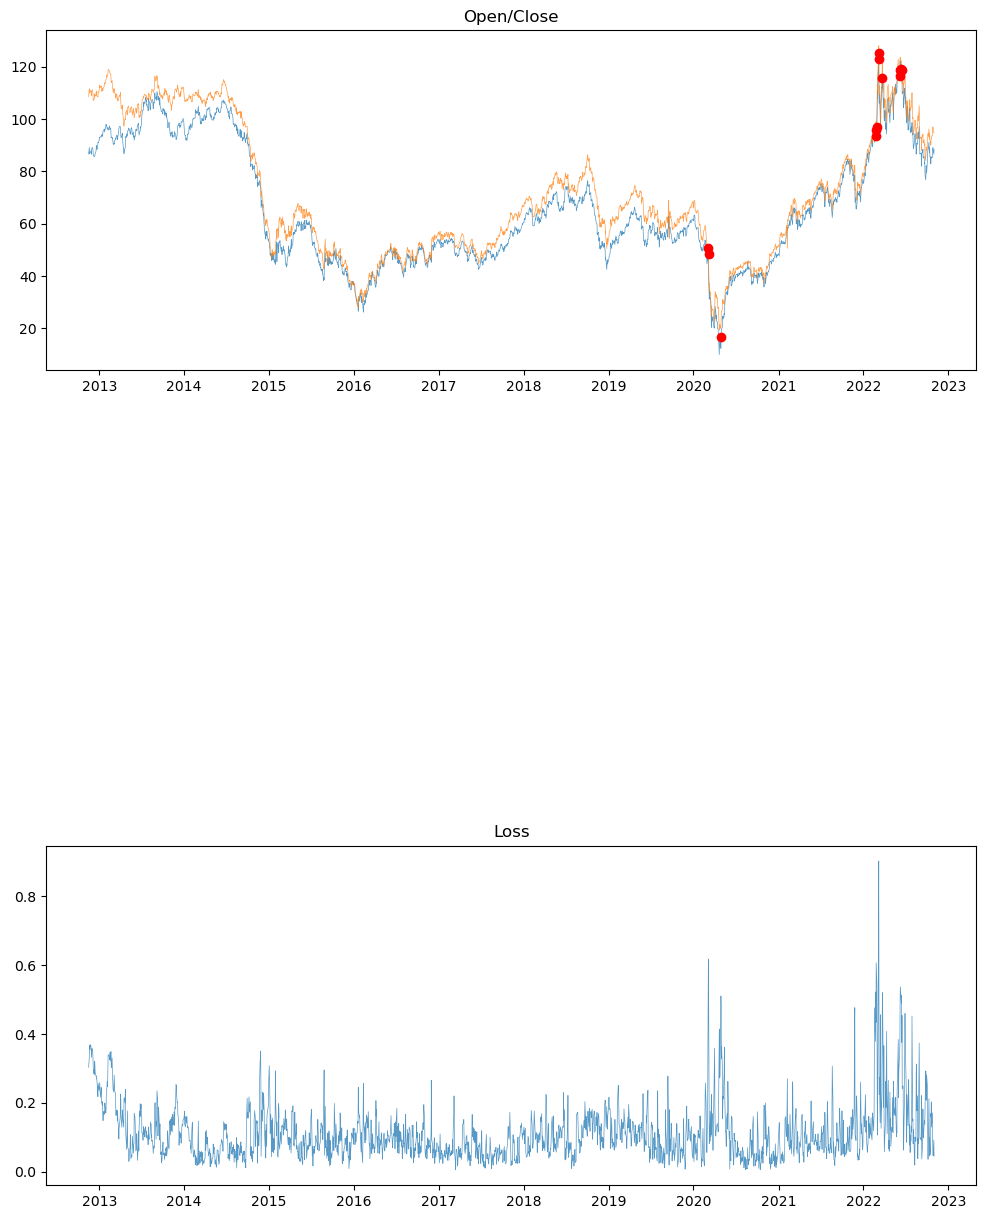

In [42]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.WTi, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Brent, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Dubai,        'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
#plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])